In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 仅处理7位序列号中的字母
train_data = []
train_label = []

In [3]:
# 根据annotion.txt读取图像
def Batch_Read(filename):
    filename = "test_data/" + filename
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    return img

In [4]:
# 1.车票票面检测
def Ticket_Detect(img):
    # 1.1.预处理
    # 中值滤波：去除黑色背景中的盐噪声，只用来做边缘提取的效果很好，size取3,5,7均可
    img_blur = cv2.medianBlur(img, 7)
    # OTSU阈值 二值化
    _, img_blur_Otsu = cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU)
    #利用Canny算子检测图像的边缘
    edges = cv2.Canny(img_blur_Otsu, 50, 150, apertureSize = 3)
    
    #1.2.寻找矩形位置并分割
    # 获取轮廓
    (contours, _) = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    for i, c in enumerate(contours):  #遍历轮廓
        rect = cv2.minAreaRect(c)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
        box = np.int0(cv2.boxPoints(rect))  # 获取最小外接矩形的 4个顶点坐标
    
        # 根据面积过滤不需要的矩形（估计车票为700x1000）
        area = cv2.contourArea(box)
        if area < 400000: continue
        if area > 1000000: continue    
    
        rect_w, rect_h = int(rect[1][0]) + 1, int(rect[1][1]) + 1  # 最小外接矩形的宽和高        
        angle = rect[2]  #获取矩形相对于水平面的角度
        #以矩形的右下角为旋转中心
        if (rect_w > rect_h):
            x0, y0 = int(box[0][0]), int(box[0][1])
            M = cv2.getRotationMatrix2D((x0, y0), angle, 1)
        else:        
            t = rect_h
            rect_h = rect_w
            rect_w = t
            x0, y0 = int(box[3][0]), int(box[3][1])
            M = cv2.getRotationMatrix2D((x0, y0), angle - 90, 1)
    
        img_ro = cv2.warpAffine(img, M, (img.shape[1] * 2, img.shape[0]))
        img_seg = img_ro[(y0 - rect_h) : y0, x0 : (x0 + rect_w)]
        
        
        #1.3.倒立校正
        #计算最上方和最下方的平均灰度值
        avg1 = np.average(img_seg[0:75, 0:rect_w])
        avg2 = np.average(img_seg[rect_h-75:rect_h,0:rect_w])
        img_fix = np.copy(img_seg)
        if (avg1 < avg2):
            M = cv2.getRotationMatrix2D((rect_w / 2, rect_h / 2), 180, 1)
            img_fix = cv2.warpAffine(img_seg, M, (rect_w, rect_h))
        
        return img_fix, rect_w, rect_h



In [5]:
#2.2处理7位序列号
def Num_7(img, img_con, rect_w, rect_h):
    box_7 = np.array([int(rect_h * 0.03), int(rect_w * 0.03), int(rect_h *0.16), int(rect_w * 0.35)]).reshape(2, 2)
    img_7 = img[box_7[0,0]:box_7[1,0], box_7[0,1]:box_7[1,1]]
    
    # 观察到序列号的灰度值范围为80~100，大于文字灰度值0~30
    _, img_7_bi = cv2.threshold(~img_7, 225, 0, cv2.THRESH_TOZERO_INV)
    # 开运算处理文字的边缘
    ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    rectangle = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    img_7_open = cv2.morphologyEx(img_7_bi, cv2.MORPH_OPEN, ellipse)
    img_7_blur = cv2.blur(img_7_open, (9, 9))
    _, img_7_open_otsu = cv2.threshold(img_7_blur, 0, 255, cv2.THRESH_OTSU)
    img_7_con = cv2.morphologyEx(~img_7_open_otsu, cv2.MORPH_OPEN, rectangle)
    
    
    # 获取轮廓
    (contours, _) = cv2.findContours(~img_7_con, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    c_max = contours[0]
    area_max = cv2.contourArea(c_max)
    for i, c in enumerate(contours):  #遍历轮廓
        # 找到面积最大的连通区域
        area = cv2.contourArea(c)
        if area_max < area:
            area_max = area
            c_max = c
    rect_7_max = cv2.minAreaRect(c_max)  # 生成最小外接矩形，得到最小外接矩形的（中心(x,y), (宽,高), 旋转角度）
    box_7_max = np.int0(cv2.boxPoints(rect_7_max))  # 获取最小外接矩形的 4个顶点坐标
    box_7_max[:,0] += box_7[0,1]
    box_7_max[:,1] += box_7[0,0]
    
    x_min = np.min(box_7_max[:,0]) - 2
    x_max = np.max(box_7_max[:,0]) + 4
    y_min = np.min(box_7_max[:,1]) - 2
    y_max = np.max(box_7_max[:,1]) + 2

    # 防止未完全连通的情况
    if (x_max - x_min < 250):
        num = round((x_max - x_min) / 29)
        step_x = (x_max - x_min) / num + 1
        if (x_min > 100): x_min = x_max - int(step_x * 7)
        elif (x_max < 250): x_max = x_min + int(step_x * 7)
        
    #估计数字的宽度
    step_x = (x_max - x_min) / 7
    
    #利用灰度值找到第一个数字的起始位置
    _, img_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU) 
    x_1 = x_max - int(step_x * 6) - 5
    while(np.min(img_otsu[y_min:y_max,x_1]) < 100):
        x_1 += 1
    x_2 = x_1
    while(np.min(img_otsu[y_min:y_max,x_2]) >= 100):
        x_2 += 1
    
    gap = x_2 - x_1
    step_x_new = (x_max - x_2) / 6 + gap / 16 
    if (step_x_new > (x_max - x_min) / 8):
        step_x = step_x_new
        
    
    x_4 = x_max
    for i in range(1, 7):
        x_3 = x_max - round(step_x * i)
        box = np.array([[x_3, y_max],[x_3, y_min],[x_4, y_min],[x_4,y_max]])
        cv2.drawContours(img_con, [box], 0, (0, 0, 255), 2)
        x_4 = x_3

    box_ = np.array([[x_min, y_max],[x_min, y_min],[x_3, y_min],[x_3,y_max]])
    cv2.drawContours(img_con, [box_], 0, (0, 0, 255), 2)
        
    data = np.array(img_otsu[y_min:y_max, x_min:x_3]) / 255.0
    data = cv2.resize(data,(20, 20), interpolation = cv2.INTER_NEAREST)
    train_data.append(data)
        
    return img_con

In [6]:
with open('annotation.txt', 'r') as file_r:
    for row in file_r:
        filename, num_21, num_7 = row.split()
        train_label.append(num_7[0])
        img = Batch_Read(filename)
        img_fix, rect_w, rect_h = Ticket_Detect(img)
        img_con_7 = Num_7(img_fix, img_fix, rect_w, rect_h)

L


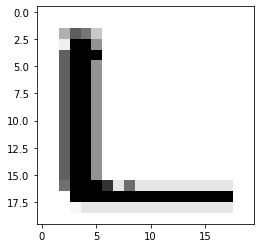

In [7]:
pos = 11
print(train_label[pos])
plt.imshow(train_data[pos], cmap = 'gray')

In [8]:
from skimage.feature import hog
from sklearn import svm

X = []
for data in train_data:
    fd = hog(data, pixels_per_cell = (4, 4),
              cells_per_block = (2, 2), multichannel = False, feature_vector = True)
    X.append(fd)
X = np.array(X)
Y = np.reshape(np.array(train_label), (-1,))
clf = svm.SVC(C = 1.0)
clf.fit(X, Y)


SVC()

In [9]:

# 保存模型参数
import joblib
joblib.dump(clf, 'char_7_svm.pkl');